# Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Obtenção dos dados

In [2]:
# Listar arquivos no diretório acima
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)


# PLSR

In [3]:
X = df_raw.iloc[:, 7:].values
y = df_raw['SST'].values

In [92]:
def pretreat(Xcal, Xtest, methods):
    if 'center' in methods:
        # Centraliza Xcal
        mean_Xcal = Xcal.mean(axis=0)
        Xcalp = Xcal - mean_Xcal
        
        # Centraliza Xtest usando a média de Xcal
        Xtestp = Xtest - mean_Xcal
        return Xcal, Xcalp, Xtest

def plsnipals(X, Y, A):
    # The NIPALS algorithm for both PLS-1 (a single y) and PLS-2 (multiple Y)
    # X: n x p matrix
    # Y: n x m matrix
    # A: number of latent variables

    varX = np.sum(X ** 2)
    varY = np.sum(Y ** 2)

    W = np.empty((X.shape[1], A))
    T = np.empty((X.shape[0], A))
    P = np.empty((X.shape[1], A))
    Q = np.empty((Y.shape[1], A))

    for i in range(A):
        error = 1
        u = Y[:, 0]
        niter = 0

        while error > 1e-8 and niter < 1000:  # for convergence test
            w = X.T @ u / (u.T @ u)
            w /= np.linalg.norm(w)
            t = X @ w
            q = Y.T @ t / (t.T @ t)  # regress Y against t
            u1 = Y @ q / (q.T @ q)
            error = np.linalg.norm(u1 - u) / np.linalg.norm(u)
            u = u1
            niter += 1

        p = X.T @ t / (t.T @ t)
        X -= t.reshape(-1, 1) @ p.reshape(1, -1)
        Y -= t.reshape(-1, 1) @ q.reshape(1, -1)

        # store
        W[:, i] = w
        T[:, i] = t
        P[:, i] = p
        Q[:, i] = q

    # calculate explained variance
    R2X = np.diag(T.T @ T @ P.T @ P) / varX
    R2Y = np.diag(T.T @ T @ Q.T @ Q) / varY

    Wstar = W @ np.linalg.inv(P.T @ W)
    B = Wstar @ Q.T
    Q = Q.T

    return W, T, P, Q, Wstar, B, R2X, R2Y


def plscv(X, y, A, K, method='center', PROCESS=1, order=2):
    if order == 0:
        indexyy = np.argsort(y)
        X = X[indexyy]
        y = y[indexyy]
    elif order == 1:
        indexyy = np.random.permutation(len(y))
        X = X[indexyy]
        y = y[indexyy]
    elif order == 2:
        indexyy = np.arange(len(y))
        X = X[indexyy]
        y = y[indexyy]

    Mx, Nx = X.shape
    A = min([X.shape[1], A])
    yytest = np.empty(Mx)
    YR = np.empty((Mx, A))

    groups = 1 + np.arange(Mx) % K
    for group in range(1, K+1):
        calk = np.where(groups != group)[0]
        testk = np.where(groups == group)[0]

        Xcal, ycal = X[calk], y[calk]
        Xtest, ytest = X[testk], y[testk]

        # data pretreatment
        Xs, xpara1, xpara2 = pretreat(Xcal, Xtest, method)
        ys, ypara1, ypara2 = pretreat(ycal, ytest, method)
        print("Xpara1 shape:", xpara1.shape)
        print("Xpara2 shape:", xpara2.shape)
        print("ypara1 shape:", ypara1.shape)
        print("ypara2 shape:", ypara2.shape)
        
        y_arr = np.array([y]).T

        W, T, P, Q, Wstar, B, r2_x, r2_y = plsnipals(X, y_arr, A)  # no pretreatment.

        yp = []
        for j in range(1, A+1):
            B = Wstar[:, :j] @ Q[:j]
            print("B", B.shape)
            # calculate the coefficient linking Xcal and ycal.
            C = (ypara2 * B).T / xpara2
            print("C", C.shape)
            coef = np.concatenate((C, ypara1 - (xpara1 * C)))
            
            # predict
            Xteste = np.hstack((Xtest, np.ones((Xtest.shape[0], 1))))
            ypred = Xteste @ coef
            yp.append(ypred)

        YR[testk] = np.array(yp).T
        yytest[testk] = ytest
        if PROCESS == 1:
            print(f'The {group}th group finished.')

    # return the original order
    YR[indexyy] = YR
    y[indexyy] = y

    # mean and sd of squared error
    error = YR - np.tile(y, (1, A))
    error2 = error ** 2
    error2_MEAN = np.sum(error2, axis=0) / Mx
    error2_SD = np.sqrt(np.sum((error2 - np.tile(np.mean(error2, axis=0), (Mx, 1))) ** 2, axis=0) / (Mx - 1))

    # calculate Q2
    cv = np.sqrt(error2_MEAN)
    index = np.argmin(cv)
    indexSD = np.where(error2_MEAN <= np.min(error2_MEAN) + error2_SD[index])[0][0]
    RMSEP = cv[index]
    SST = np.sum((yytest - np.mean(y)) ** 2)
    Q2 = 1 - np.sum((YR - np.tile(y, (1, A))) ** 2, axis=0) / SST

    # output
    CV = {
        'method': method,
        'Ypred': YR,
        'predError': error,
        'RMSECV': cv,
        'Q2': Q2,
        'RMSECV_min': RMSEP,
        'Q2_max': Q2[index],
        'optLV': index,
        'note': '*** The following is based on global min MSE + 1SD',
        'RMSECV_min_1SD': cv[indexSD],
        'Q2_max_1SD': Q2[indexSD],
        'optLV_1SD': indexSD
    }
    CV_df = pd.DataFrame([CV]).T


    return CV_df

In [71]:
##Construção do modelo
def caltest(X, y, test_size, method, random_state):
    methods = ['center']  # Método de pré-processamento: centralização

    # Define o número de folds
    n_splits = int(100 / (100 - test_size))
    
    # Inicializa o KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Obter o primeiro split do KFold
    for train_index, test_index in kf.split(X):
        Xcal, Xtest = X[train_index], X[test_index]
        ycal, ytest = y[train_index], y[test_index]
        break  # Pegue apenas o primeiro split
    
    # info pode ser um dicionário armazenando alguns metadados sobre a divisão
    info = {
        'method': method,
        'test_size': test_size,
        'random_state': random_state,
        'n_splits': n_splits
    }
    
    print("É esperado que a maior parte das amostras para teste sejam do centro da distibuição")
    # Criação do gráfico
    plt.figure(figsize=(8, 6))

    # Plotar ycal e ytest
    plt.plot(ycal, ycal, 'b*', label='ycal')
    plt.plot(ytest, ytest, 'ro', label='ytest')

    # Adicionar legenda, grid e rótulos
    plt.legend()
    plt.grid(True)
    plt.xlabel('Referência')
    plt.ylabel('Referência')

    # Mostrar o gráfico
    plt.show()

    return info, Xcal, Xtest, ycal, ytest

É esperado que a maior parte das amostras para teste sejam do centro da distibuição


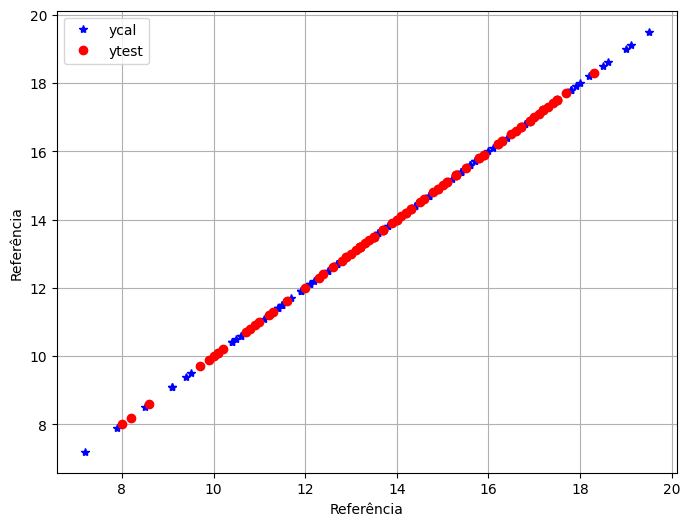

Info: {'method': 'k', 'test_size': 70, 'random_state': 0, 'n_splits': 3}
Xcal shape: (166, 2151)
Xtest shape: (84, 2151)
ycal shape: (166,)
ytest shape: (84,)


In [72]:
# Exemplo de uso
test_size = 70                 # 70% para calibração, 30% para teste
method = 'k'                   # Método, indicando validação cruzada k-fold
random_state = 0               # Semente para o gerador de números aleatórios
options = ['none']             # Opções, não usadas neste exemplo, mas incluídas para completude


info, Xcal, Xtest, ycal, ytest = caltest(X, y, test_size, method, random_state)
print("Info:", info)
print("Xcal shape:", Xcal.shape)
print("Xtest shape:", Xtest.shape)
print("ycal shape:", ycal.shape)
print("ytest shape:", ytest.shape)

In [93]:
print(type(Xcal))
print(type(ycal))
n_comp = 10
cv = 10
methods = 'center'
df = plscv(Xcal, ycal, n_comp, cv, methods, 1, 2)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Xpara1 shape: (149, 2151)
Xpara2 shape: (17, 2151)
ypara1 shape: (149,)
ypara2 shape: (17,)
B (2151, 1)
C (17, 2151)


ValueError: operands could not be broadcast together with shapes (149,2151) (17,2151) 